In [1]:
from sklearn.manifold import TSNE
import yaml
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

sys.path.append(os.path.abspath('..'))
from prompt import PromptEngine

In [2]:
# from BCEmbedding import EmbeddingModel
from langchain_community.embeddings import HuggingFaceEmbeddings
sentences = ['python 是什么', '请介绍一下 python']
# model = EmbeddingModel(model_name_or_path="maidalun1020/bce-embedding-base_v1")
model = HuggingFaceEmbeddings(model_name='maidalun1020/bce-embedding-base_v1')

/data/zhelonghuang/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/zhelonghuang/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
embeddings = model.embed_documents(sentences)

In [5]:
engine = PromptEngine('../config/story.yml')
engine.merge_stories_from_yml('../config/github-issue.story.yml')
engine.merge_stories_from_yml('../config/qq.story.yml')

sentences = []
labels = []
for story in engine.stories:
    sentences.append(story.message)
    labels.append(engine.intent2id[story.intent])
sentences, labels

(['请问 property.json 如何配置？',
  '我的自动补全无法使用，是不是有bug？',
  '帮我上传一下这份数据',
  'surface了解一下？',
  '大佬们，为啥我的digital ide启动之后所有功能都没启动捏？我配置了property文件，然后插件的vivado路经和modelsim路经都加上了',
  '这群要被chisel夺舍了吗',
  'Metals一开直接报错',
  '话说digital-ide打开大的verilog卡死了',
  '请问一下，第一次点击对文件仿真可以出波形文件，再次点击的时候就会提示unknown module type了。是哪个配置没配置好？',
  '怎么调整是哪个版本的vivado来构建工程呢',
  '咱们这个插件win7的vscode是不是只能用很早之前的版本',
  '帮我将这份数据保存到服务器上',
  '他这个意思是 单个功耗很低 但是功耗低那肯定性能就寄 频率肯定不高 靠人多',
  '我平时写代码就喜欢喝茶',
  '感觉现在啥都在往AI靠',
  '请问你们自动对齐插件用的啥？',
  '不得不放一下我的咖啡笔记了',
  'stm32有什么好玩的应用不',
  '别人设置的肯定有点不合适自己的',
  'http://hehezhou.cn/register2024/AArch64-regindex.html',
  '因为他们py本领不是很强，需要这些东西辅助',
  '写C写多了，顺手在pycharm写了个main.c',
  '好流畅的にほんじんです',
  '有没有接触过UI开发的，想做一款寄存器管理的工具，想把界面做的好看一点',
  '现在嘉立创也在做FPGA了？',
  '大佬们，更新0.3.3之后，用iverilog仿真，testbench中还是例化模块出错：unknown module type，这是什么原因啊？',
  '查了一下记录，2017年买的静电容',
  '我小时候电脑刚买回来一星期就被我玩坏了',
  'command not found: python',
  'path top.v is not a hdlFile 请问报这个错误大概是啥原因啊',
  '咖啡喝不了，喝了胃不舒服',
  '兄弟们有没有C语言绘图库推荐',
  '在企业里面最

In [6]:
embedding = model.embed_documents(sentences)
embedding = np.array(embedding)
embedding.shape

(185, 768)

In [7]:
tsne = TSNE(n_components=2)
plots = tsne.fit_transform(embedding)

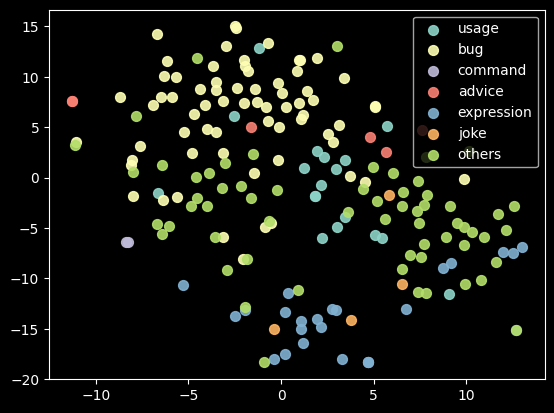

In [8]:
labels = np.array(labels)
for label in set(labels):
    mask = labels == label
    cor_plots = plots[mask]
    plt.scatter(cor_plots[:, 0], cor_plots[:, 1], s=50, alpha=0.9, label=engine.id2intent[label])
plt.legend()

In [9]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model.fit(embedding, labels)

LogisticRegression()

In [10]:
test_sentence = ['咖啡喝不了，喝了胃不舒服']
test_embedding = model.embed_documents(test_sentence)
res = log_model.predict(test_embedding)[0]
engine.id2intent[res]

'others'

In [11]:
import joblib
joblib.dump(log_model, '../model/embedding_mapping.sklearn')

['../model/embedding_mapping.sklearn']

In [12]:
log_model = joblib.load('../model/embedding_mapping.sklearn')

In [13]:
test_sentence = ['咖啡喝不了，喝了胃不舒服']
test_embedding = model.embed_documents(test_sentence)
res = log_model.predict(test_embedding)[0]
engine.id2intent[res]

'others'

## 尝试使用 EDL

使用证据网络增加不确定性计算，详细可看： [EDL（Evidential Deep Learning） 原理与代码实现](https://kirigaya.cn/blog/article?seq=154)

损失函数

$$
\mathcal L(\theta) = \sum_{i=1}^N \mathcal L_i(\theta) +\lambda_t \sum_{i=1}^N \mathrm{KL}\left(D(p_i|\tilde{\alpha}_i) || D(p_i | \bold 1)\right)
$$

In [9]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm

class SimpleERNN(nn.Module):
    in_dim: int
    out_dim: int
    alpha_kl: float
    def __init__(self, in_dim: int, out_dim: int, focal: int, alpha_kl: float):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.alpha_kl = alpha_kl
        self.focal = focal
        self.classifier = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ELU(),
        )
    
    def forward(self, inputs: torch.FloatTensor) -> tuple[torch.FloatTensor, torch.FloatTensor]:
        logits = self.classifier(inputs)
        evidence = torch.exp(logits)
        prob = F.normalize(evidence + 1, p=1, dim=1)
        return evidence, prob

    def criterion(self, evidence: torch.FloatTensor, label: torch.LongTensor) -> torch.FloatTensor:
        if len(label.shape) == 1:
            label = F.one_hot(label, self.out_dim)
        alpha = evidence + 1
        alpha_0 = alpha.sum(1).unsqueeze(-1).repeat(1, self.out_dim)
        loss_ece = torch.sum(label * (torch.digamma(alpha_0) - torch.digamma(alpha)), dim=1)
        loss_ece = torch.mean(loss_ece)
        if self.alpha_kl > 0:
            tilde_alpha = label + (1 - label) * alpha
            uncertainty_alpha = torch.ones_like(tilde_alpha).cuda()
            estimate_dirichlet = torch.distributions.Dirichlet(tilde_alpha)
            uncertainty_dirichlet = torch.distributions.Dirichlet(uncertainty_alpha)
            kl = torch.distributions.kl_divergence(estimate_dirichlet, uncertainty_dirichlet)
            loss_kl = torch.mean(kl)
        else:
            loss_kl = 0
        return loss_ece + self.alpha_kl * loss_kl    

In [12]:
in_dim = embedding.shape[1]
out_dim = max(labels) + 1
enn_model = SimpleERNN(in_dim, out_dim, 0, 0)
optimizer = torch.optim.AdamW(enn_model.parameters(), lr=1e-3)

bs = 64
sample_num = len(embedding)
sample_indice = np.arange(sample_num)
bs_num = int(np.ceil(sample_num / bs))

training_losses = []

for i in tqdm.trange(200):
    alpha_kl = min(0.9, i / 10)
    np.random.shuffle(sample_indice)    
    train_loss = 0
    for bs_i in range(bs_num):
        start = bs_i * bs
        end = min(sample_num, start + bs)
        data_indice = sample_indice[start: end]
        data = torch.FloatTensor(embedding[data_indice])
        label = torch.LongTensor(labels[data_indice])
        evidence, prob = enn_model(data)
        loss = enn_model.criterion(evidence, label)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    training_losses.append(train_loss / bs_num)

100%|██████████| 200/200 [00:00<00:00, 230.43it/s]


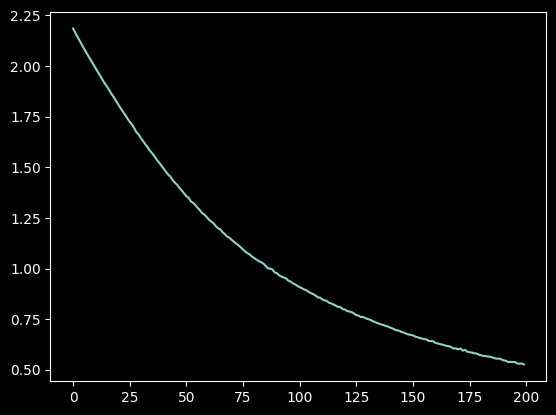

In [13]:
plt.plot(training_losses)

In [18]:
torch.save(enn_model.state_dict(), '../model/intent.enn.pth')

In [19]:
in_dim = embedding.shape[1]
out_dim = max(labels) + 1
enn_model = SimpleERNN(in_dim, out_dim, 0, 0)
state_dict = torch.load('../model/intent.enn.pth')
enn_model.load_state_dict(state_dict)

<All keys matched successfully>

In [20]:
embd = model.embed_documents(['其实是计划给linux适配的，linux和mac都是posix接口，那不是自然就适配mac了吗'])
embd = torch.FloatTensor(embd)
with torch.no_grad():
    evidence, prob = enn_model(embd)

e = evidence
alpha = e + 1
S = alpha.sum(1)
b = e / S
u = out_dim / S
u, prob, b

(tensor([0.0972]),
 tensor([[0.2197, 0.1341, 0.0202, 0.0307, 0.0252, 0.0267, 0.5433]]),
 tensor([[0.2059, 0.1202, 0.0064, 0.0168, 0.0113, 0.0129, 0.5295]]))

In [21]:
test_suite = [
    { 'input': '如何使用 digital ide 这个插件？', 'expect': 'usage' },
    { 'input': '我今天打开 vscode，发现 自动补全失效了，我是哪里没有配置好吗？', 'expect': 'usage,bug' },
    { 'input': 'path top.v is not a hdlFile 请问报这个错误大概是啥原因啊', 'expect': 'usage,bug' },
    { 'input': '我同学在学习强国看到小麦收割了，然后就买相应的股就赚了', 'expect': 'others' },
    { 'input': '我平时写代码就喜欢喝茶', 'expect': 'others' },
    { 'input': '请问报这个错误大概是啥原因啊', 'expect': 'usage,bug' },
    { 'input': '感觉现在啥都在往AI靠', 'expect': 'others' },
    { 'input': '别人设置的肯定有点不合适自己的', 'expect': 'others' },
    { 'input': '在企业里面最大的问题是碰见傻逼怎么办？', 'expect': 'others' },
    { 'input': '几乎完全不喝牛奶2333', 'expect': 'others' },
    { 'input': 'command not found: python', 'expect': 'usage,bug,others' },
    { 'input': '兄弟们有没有C语言绘图库推荐', 'expect': 'usage' },
    { 'input': '我早上开着机去打论文 回来发现我电脑切换到Linux了', 'expect': 'usage,bug,others' },
    { 'input': '我在Windows下遇到的只要问题就是对于C程序，包管理和编译管理器偶尔会不认识彼此但除此之外，都很安稳（win11除外）', 'expect': 'usage,others' },
    { 'input': '我的反撤回还能用', 'expect': 'others' },
    { 'input': '因为这是养蛊的虚拟机，放了些国产垃圾软件，得用国产流氓之王才能镇得住他们', 'expect': 'others' },
    { 'input': '你咋装了个360', 'expect': 'others' },
    { 'input': '？？？', 'expect': 'expression' },
]
for test in test_suite:
    embd = model.embed_documents([test['input']])
    embd = torch.FloatTensor(embd)
    with torch.no_grad():
        evidence, prob = enn_model(embd)

    e = evidence
    alpha = e + 1
    S = alpha.sum(1)
    b = e / S
    u = out_dim / S
    pre_label = prob.argmax(1)
    name = engine.id2intent[pre_label[0].item()]
    ok = '√' if name in test['expect'] else '×'
    print(name, test['expect'], ok, u)


usage usage √ tensor([0.0501])
bug usage,bug √ tensor([0.0773])
bug usage,bug √ tensor([0.0758])
others others √ tensor([0.1678])
others others √ tensor([0.0887])
bug usage,bug √ tensor([0.0902])
others others √ tensor([0.0453])
others others √ tensor([0.0424])
others others √ tensor([0.1416])
others others √ tensor([0.1441])
bug usage,bug,others √ tensor([0.1615])
usage usage √ tensor([0.0562])
others usage,bug,others √ tensor([0.0820])
others usage,others √ tensor([0.0798])
others others √ tensor([0.1282])
others others √ tensor([0.1034])
others others √ tensor([0.0967])
expression expression √ tensor([0.0802])
